# Figure of merit for CAT gratings

In this Jupyter notebook, I show the effective area and resolution we can expect for ARCUS with CAT gratings. 

### What's in this document and what is not
This document contains mostly results of simulations not the code and instructions to run the simulations themselves because many of the plots below require a grid of simulations, e.g. in for dofferent energies, and take while to run. Thus, those grids are run in a separate process and the relevant results (e.g. the position of the final rays on the detector) is saved in a fits file. In this notebook we then parse these fits files to extract the relevant information.

### How to read this document
This notebook is a format that displays code, plots and other output on the same html page. You can just looks that the plots (some of them are interactive and allow zoming - look for small icons that appear when you mouse cursor is above it) and my explanatory text.

Use the "toggle on/off raw code" button below to display the code to inspect in detail how the plots are made. Please let me know if you find any error or omissions. The plotting and simulations are done in Python but even if you do not use that language, you can probably see which columns or rows of the fits data files I compare in plots.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import sys
from glob import glob
import functools

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import astropy
import astropy.coordinates
from astropy.table import Table, Column
import astropy.units as u

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import marxs
from marxs.source import PointSource, FixedPointing
# Add location of arcus definitions to path (unless in same directory).
# Not found automatically, because I did not install it as a module.
sys.path.append('..')
import arcus.arcus as arcus

In [4]:
#import mpld3
#mpld3.disable_notebook()

In [5]:
datadir = '/melkor/d1/guenther/Dropbox/ARCUS/rays/semi-compact/'
dataroot = '/melkor/d1/guenther/Dropbox/ARCUS/rays/'
figureout = '/melkor/d1/guenther/Dropbox/ARCUS/plots/'

In [6]:
rayfiles = glob(os.path.join(datadir, '*.fits'))
rayfiles.sort()

In [7]:
allrays = [Table.read(f) for f in rayfiles]

In [8]:
# Each file of for a single energy
wave = np.array([(t['energy'][0] * u.keV).to(u.Angstrom, equivalencies=u.spectral()).value for t in allrays])

In [9]:
def fractional_aeff(photons, orders, filterfunc=None, col='order'):
    '''Calculate the fraction of photons that are detected in a specific order
    
    While written for calculating Aeff per order, this can be used with any discrete
    quantiy, e.g. Aeff per CCD.
    
    Parameters
    ----------
    photons : `astropy.table.Table`
        Photon event list
    orders : np.array
        Orders for w
    filterfunc : callable or ``None``
        If not ``None``, a function that takes the photon table and returns an
        index array. This can be used, e.g. filter out photons that hit particular CCDs or
        hot columns.
    col : string
        Column name for the order column.
        
    Returns
    -------
    prop : np.array
        Probability for a photon in a specific order to be detected.
    '''
    prob = np.zeros_like(orders, dtype=float)
    for i, o in enumerate(orders):
        ind = (photons[col] == o)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)
        prob[i] = np.sum(photons['probability'][ind]) / len(photons)
    return prob

## Effective area

In [10]:
orders = np.arange(-10, 1)
photonfilter = lambda p: np.isfinite(p['probability']) & (p['CCD_ID'] >=0)
aeff = np.array([fractional_aeff(p, orders, filterfunc=photonfilter) for p in allrays])

In [11]:
outtab = Table(aeff, names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Aeff.csv'), format='ascii.csv', overwrite=True)

In [12]:
# In principle, the absolute area is an input to the ray-trace and that infomation is already availble
# in the ray files.
# However, I chose to normalize all that to 1 cm^2 and multiply with this factor here, because that makes
# it easier to change the number if I need new plots for an updated design later.
Ageometric = 1434.5 * 2

In [13]:
colorcycle = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33']

def plot_aeff(aeff):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(wave, aeff[:, -1] * Ageometric * 2, 'k:', label='0th order')
    ax.plot(wave, np.sum(aeff[:, :-1], axis=1) * Ageometric * 2, 'k', label='all dispersed\norders')

    for i, c in zip(np.arange(3, 10), colorcycle):
        ax.plot(wave, aeff[:, i] * Ageometric * 2, label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('$A_{eff}$ [cm$^2]$')
    temp = ax.set_xlim([8, 55])
    return fig, ax

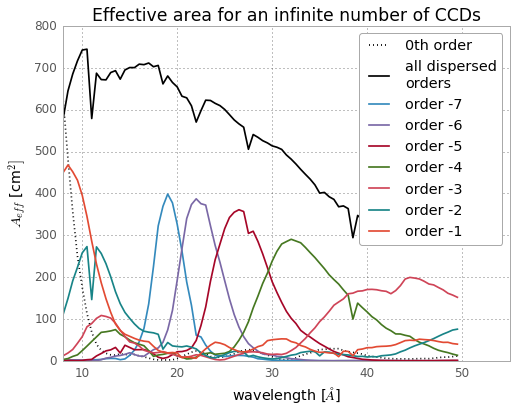

In [14]:
fig, ax = plot_aeff(aeff)
temp = ax.set_title('Effective area for an infinite number of CCDs')

In [15]:
orders = np.arange(-10, 1)
photonfilter = lambda p: np.isfinite(p['probability']) & (p['facet'] < 2000)
photonfilterm = lambda p: np.isfinite(p['probability']) & (p['facet'] >= 2000)

id_ccd = np.arange(0, 90)
n_ccd = np.array([fractional_aeff(p, id_ccd, filterfunc=photonfilter, col='CCD_ID') for p in allrays])
n_ccdm = np.array([fractional_aeff(p, id_ccd, filterfunc=photonfilterm, col='CCD_ID') for p in allrays])

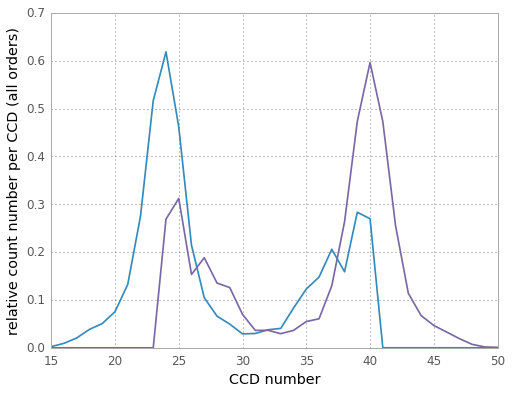

In [16]:
plt.plot(id_ccd, n_ccd.sum(axis=0))
plt.plot(id_ccd, n_ccdm.sum(axis=0))

plt.xlim([15, 50])
plt.xlabel('CCD number')
plt.ylabel('relative count number per CCD (all orders)')

In a CAT grating, photons are predominatly diffracted into orders that are located at roughly twice the blaze angle. However, other orders also receive some signal. For one configuration of CCD detectors placed on a Rowland Circle, this figure shows the total number of photons that each detector will see (assuming a flat input spectrum). The two lines show the number of photons for different pairs of channels, because each pair of channels has their own optical axis.

For the blue line, the zeroth order is located on CCD 40, most of the diffrected signal is seen in CCDs 20-30.
From this plot, we can determine which are the 16 CCDs that get the most signal and then realize that configuration in the ARCUS hardware.

In [17]:
# Find the top 16 CCDs by count number
counts_all_channels = np.sum(n_ccd + n_ccdm, axis=0)
topccdids = np.argsort(counts_all_channels)[-16:]
topccdids.sort()
print topccdids

[22 23 24 25 26 27 28 29 35 36 37 38 39 40 41 42]


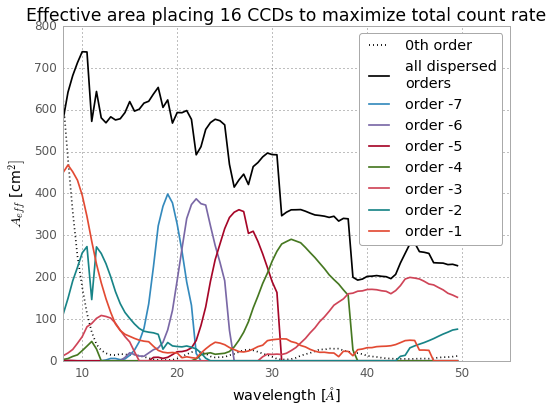

In [18]:
# Idea: Add plot from above (infinite nubmer of CCDs) e.g. in dashed (remove 0th order from plot)
# or with lower opacity
# That would enable an easier comparison

def photonfilter_general(photons, topccdids):
    ind = np.zeros(len(photons), dtype=bool)
    for i in topccdids:
        ind = ind | (photons['CCD_ID'] == i)
    return ind & np.isfinite(photons['probability'])

photonfiltertopccds = functools.partial(photonfilter_general, topccdids=topccdids)

aeff_16ccd = np.array([fractional_aeff(p, orders, filterfunc=photonfiltertopccds) for p in allrays])

fig, ax = plot_aeff(aeff_16ccd)
plt.title('Effective area placing 16 CCDs to maximize total count rate')


In [19]:
outtab = Table(aeff_16ccd, names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Aeff_16CCDs.csv'), format='ascii.csv', overwrite=True)

Effective areas assuming that ARCUS contains the 16 CCDs the cover the largest number of photos as determined from the last plot. Steps appear in the total effective area curve, when an order moved beyond the area covered with chips (e.g. order -4 at 38 Ang). Gaps indicate an order that hits a chip gap (e.g. order -7 at 12 Ang). In reality there will be more chip gaps, but the limited resolution of the simulations (wavelength grid as 1 Ang wide steps) not all of them are seen here.

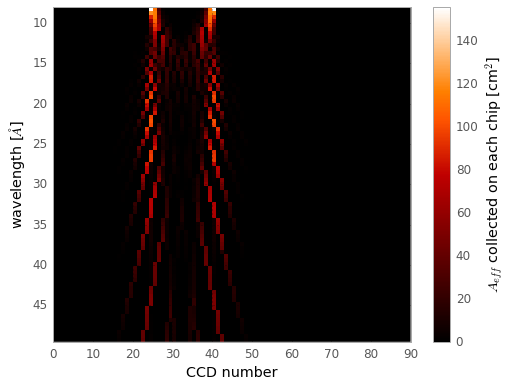

In [20]:
plt.imshow((n_ccd + n_ccdm) * Ageometric, interpolation='none',
          extent=( 0, len(counts_all_channels), wave[-1], wave[0]), aspect='auto')
plt.ylabel('wavelength [$\AA{}$]')
plt.xlabel('CCD number')
colbar = plt.colorbar(label='$A_{eff}$ collected on each chip [cm$^2$]')

This is another way of showing which CCDs are detecting the most signal. As in the plot above, the CCD ID number os shown on the x-axis, but instead of summing the signal over all wavelength, it's shown here for each wavelength. 
There are two pairs of channels, so everything is mirrored at about CCD ID 32 or so. The figure shows roughly diagonal strips. As the wavelength increases from the top towards the bottom of the plot, a particular grating order gets dispersed to larger angles, causing the strip to move outward. As the order moves away from the preferred angle, it gets wekaer and weaker and more photons are found in the next lower order, which can be seen as a next line appearing. For most wavelength the signal is concentated in one or two orders for each wavelength.

## Spectral resolving power

I define the resolving power as:
$R = \frac{\lambda}{\Delta \lambda} = \frac{d_x}{FWMH}$
where $\lambda$ is the wavelength of a spectral line with negligible intrinsic
width, and $\Delta \lambda$ is the observed width of this feature. Since the
detector does not give the wavelength directly, $d_x$ and the $FWHM$ are linear
distances measured along a curved detector that follows the Rowland circle. The $FWMH$ is the full width at
half maximum of the event distribution and $d_x$ is the distance between
the center of a diffracted order and the zeroth order.

In [21]:
from astropy.stats import sigma_clipped_stats

def resolving_power(photons, orders, filterfunc=None, col='proj_x', zeropos=None):
    '''Calculate the resolution in a specific order
    
    If fewer than 20 photons are detected in a single order, this function returns
    nan values.
        
    Parameters
    ----------
    photons : `astropy.table.Table`
        Photon event list
    orders : np.array
        Orders for w
    filterfunc : callable or ``None``
        If not ``None``, a function that takes the photon table and returns an
        index array. This can be used, e.g. filter out photons that hit particular CCDs or
        hot columns.
    col : string
        Column name for the order column.
    zeropos : float or ``None``
        Value of column `col` where the zeroth order is found. If not given, this is 
        calculated (assuming the zeroth order photons are part of the event list).
        
    Returns
    -------
    prop : np.array
        Probability for a photon in a specific order to be detected.
    '''
    if zeropos is None:
        ind = (photons['order'] == 0)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)
        zeropos, medzeropos, stdzero = sigma_clipped_stats(photons[col][ind])

    pos = np.zeros_like(orders, dtype=float)
    std = np.zeros_like(orders, dtype=float)
    
    for i, o in enumerate(orders):
        ind = (photons['order'] == o)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)

        if ind.sum() > 20:
            meanpos, medianpos, stdpos = sigma_clipped_stats(photons[col][ind])
        else:
            meanpos, stdpos = np.nan, np.nan
        pos[i] = meanpos
        std[i] = stdpos
    res = np.abs(pos - zeropos) / (std * 2.3548)
    return res, pos, std

In [22]:
# Split the two pairs of channels, because they have different zero order positions.
allrays1 = [p[p['facet'] < 2000] for p in allrays]
allrays2 = [p[p['facet'] >= 2000] for p in allrays]

In [23]:
photonfilter = lambda p: np.isfinite(p['probability']) & (p['CCD_ID'] >=0)
res = np.array([resolving_power(p, orders, filterfunc=photonfilter, zeropos=0) for p in allrays1])

In [24]:
outtab = Table(res[:, 0, :], names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Resolvingpower.csv'), format='ascii.csv')

In [25]:
def plot_res(res):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i, c in zip(np.arange(3, 10), colorcycle):
        ax.plot(wave, res[:, 0, i], label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    temp = ax.set_xlim([8, 55])
    return fig, ax

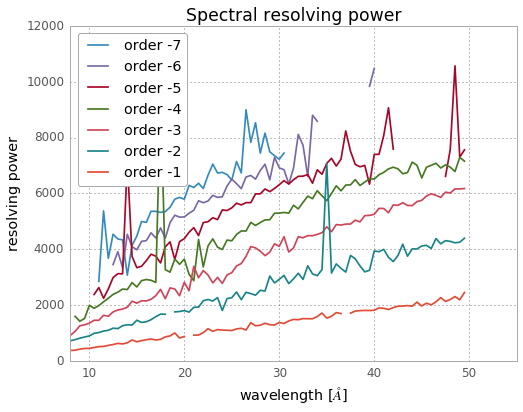

In [26]:
fig, ax = plot_res(res)
temp = ax.set_title('Spectral resolving power')

Spectral resolving power for individual orders. There can be some wired features in this plot, that are essentially numerirical:

- *gaps*: The resolving power is only calcualted if a certain minimum number of photons is detected in an order. If most photons fall into a chip gap, then values on the curve might be missing.
- *spikes*: If a spectral order falls very close to a chip gap, the distribution of detected photons might seem very small, e.g. if half the order falls into the gap, the FWHM of the distribution of detected photons is only about 1/2 of the real value, leading to an upward spike in resolving power in the plot.

Since I understand where these features are coming from and it's easy to ignore them when looking by eye, I've decided to deal with them in detail later. For now, just ignore them.

## Figure of merit

In [27]:
def combine_figures_of_merit(aeff, res):
    out = np.zeros(aeff.shape)
    for i in range(len(out)):
        res_i = res[:, 0, i]
        sort_res = np.argsort(res_i)
        merits = np.sqrt(res[:, 0, i] * aeff[:, i] * Ageometric * 2)
        out[i] = np.nansum(merits[sort_res[:2]])

    return out

In [28]:
def plot_merrit(aeff, res):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(wave, combine_figures_of_merit(aeff, res), 'k',
    #            label='top 2 orders\nadded')
    for i, c in zip(np.arange(0, 10), colorcycle):
        ax.plot(wave, np.sqrt(res[:, 0, i] * aeff[:, i] * Ageometric * 2),
                label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('Figure of merrit [cm]')
    temp = ax.set_xlim([8, 55])
    return fig, ax

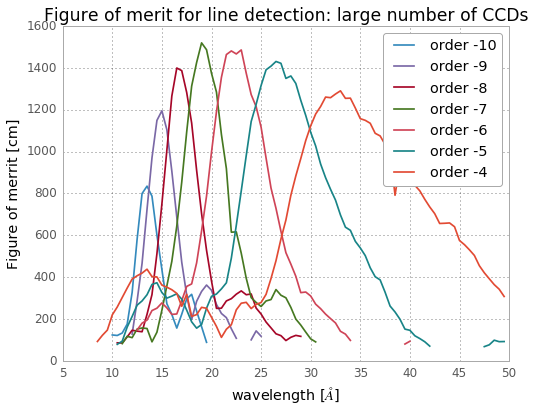

In [29]:
fig, ax = plot_merrit(aeff, res)
ax.set_xlim([5, 50])
temp = ax.set_title('Figure of merit for line detection: large number of CCDs')

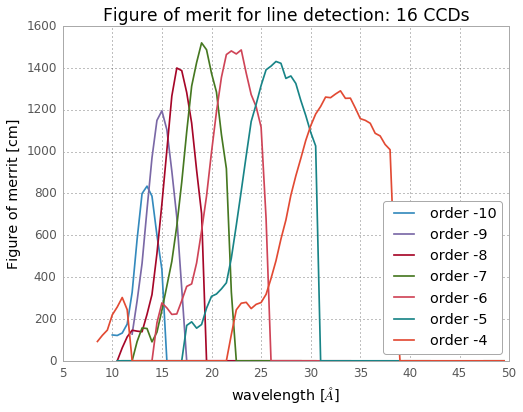

In [30]:
fig, ax = plot_merrit(aeff_16ccd, res)
ax.set_xlim([5, 50])
temp = ax.set_title('Figure of merit for line detection: 16 CCDs')

## An example on the detector
In the next few cells, I will run an example through the ray-trace code and make plots that show the actual detector image that this would produce.
Keep in mind that the current detector model is very simple: There is a uniform CCD contamination and an energy-dependend factor for the quantum efficiency, but otherwise the detector is perfect: No read-out streaks, no pile-up, and no chanrge-transfer inefficiency (all of which are to be expected in real detector) are simulated. Also, this particular simulation does not include any sort of background (astrophysical or instrumental).

For this example, I chose the spectrum of EQ Peg A (an active star) with the parameters from [Liefke et al. (2008)](http://adsabs.harvard.edu/abs/2008A%26A...491..859L). In practice, there is a close companion EQ Peg B and the two spectra will overlap in ARCUS, but for the purposes of this example, EQ Peg A alone will be good enough to represent an emission line spectrum.

The code below reads the input spectrum from table of energy and flux density that I generated with Sherpa (could have used XSPEC or ISIS, too).

In [31]:
EQPegAspec = Table.read('../inputdata/EQPegA_flux.tbl', format='ascii', names=['energy', 'flux'])
# restrict table to ARCUS energy range
EQPegAspec = EQPegAspec[(EQPegAspec['energy'] > 0.25) & (EQPegAspec['energy'] < 1.5)]

EQPegAcoord = astropy.coordinates.SkyCoord.from_name("EQ Peg A")

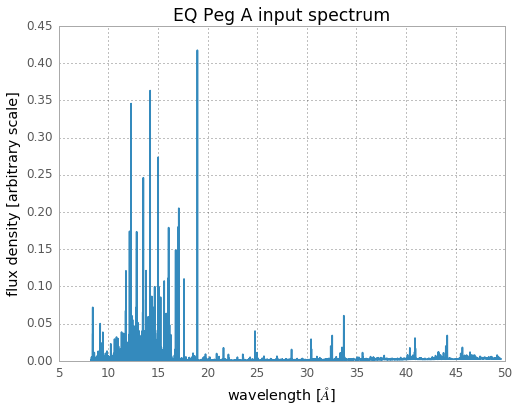

In [32]:
plt.plot((EQPegAspec['energy'] * u.keV).to(u.Angstrom, equivalencies=u.spectral()), EQPegAspec['flux'])
plt.xlabel('wavelength [$\AA{}$]')
plt.ylabel('flux density [arbitrary scale]')
title = plt.title('EQ Peg A input spectrum')

In [33]:
# Simulations runs for a while if we want a large number of photons and thus I run it in an external script.
# Read result for plotting here:
eqpegA = Table.read(os.path.join(dataroot, 'EQPegA.fits'))

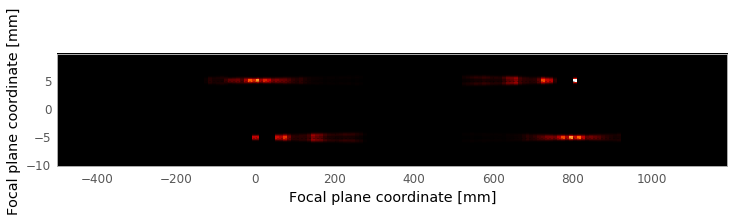

In [34]:
import matplotlib.colors

ind = photonfiltertopccds(eqpegA)

fig = plt.figure(figsize=(12,2))
ax = fig.add_subplot(111)
out = ax.hist2d(eqpegA['proj_x'][ind], eqpegA['proj_y'][ind], weights=eqpegA['probability'][ind],
          bins=[np.arange(-500,1200,10.), np.arange(-10, 10, .2)],
          )#norm=matplotlib.colors.LogNorm())
ax.set_xlabel('Focal plane coordinate [mm]')
temp = ax.set_ylabel('Focal plane coordinate [mm]')

Image of the total grating signal detected. The images is shown in focal plane coordinates, projected from the positions where the photons are detected on CCDs that follow the Rowland cirlce. This is **not** the same as the image a flat detector in the focal plane would see. **Note: X and y axis have very different scales!**

The spectrum seems to open up a little bit in the middle because the spectral focus does not coincide with the imaging focus. In other words, the detectors are placed to increase the spectral resolution, at the cost of the sub-optimal width in cross-dipersion direction.

In [35]:
def rect_from_ccd_geometry(geometry):
    bl = geometry['center'] + geometry['v_y'] + geometry['v_z']
    width = -2. * geometry['v_y'][1]
    height = -2. * geometry['v_z'][2]
    # Scale that to fit in range [0, 1]
    return [(bl[1] + 200.) / 1200., bl[2]/1200.+0.5, width/1200., height/1200.]

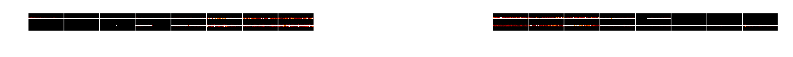

In [36]:
fig = plt.figure(figsize=(12,12))

for i in topccdids:
    ax = fig.add_axes(rect_from_ccd_geometry(arcus.det.elements[i].geometry))
    ind = eqpegA['CCD_ID'] == i
    hist, xedges, yedges = np.histogram2d(eqpegA['detpix_y'][ind], eqpegA['detpix_x'][ind], 
                            weights=eqpegA['probability'][ind],
                            range=[[0,1024], [0,2048]], bins=50
          )
    ax.imshow(hist, aspect='auto', interpolation='none', vmin=0., vmax=10)
    ax.set_axis_off()
fig.savefig(os.path.join(figureout, 'EQPegonCCD.pdf'), dpi=300)

Layout of the detectors as seen from the top. In 3-D space the detectors follow the Rowland circle, but they are plotted here as they would be seen from the top. Some dispersed photons fall beyond the boundaries of the chips shown here, but in order to restirce ARCUS to a managable number of chips, choices have to be made and this configuration maximizes the total signal for a fixed number of chips.

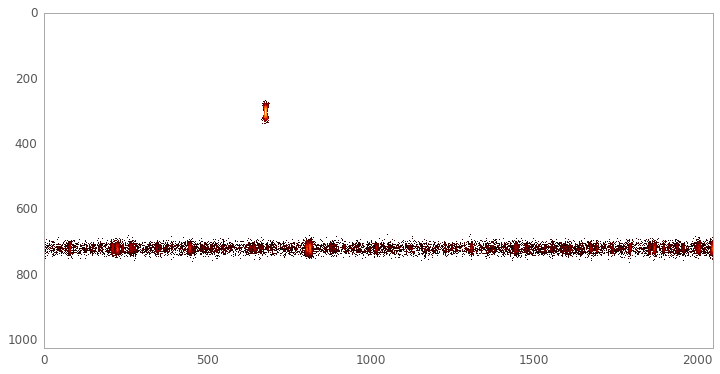

In [37]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)
ind = eqpegA['CCD_ID'] == 24
hist, xedges, yedges = np.histogram2d(eqpegA['detpix_y'][ind], eqpegA['detpix_x'][ind], 
                                weights=eqpegA['probability'][ind],
                            range=[[0,1024], [0,2048]], bins=[1024,2048]
          )
ax.imshow(hist, aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm())
ax.grid()
#cax = fig.colorbar(ax)
#ax.set_axis_off()

fig.savefig(os.path.join(figureout, 'EQPegonCCD24.pdf'), dpi=300)

This plot show a detector image for CCD 24. The image is binned to the size of the actual physical pixels and uses a logarithmic color scale. On the bottom is the spectal trace for one of the pairs of channels, at the top is the zeroth order for the other pair of channels.

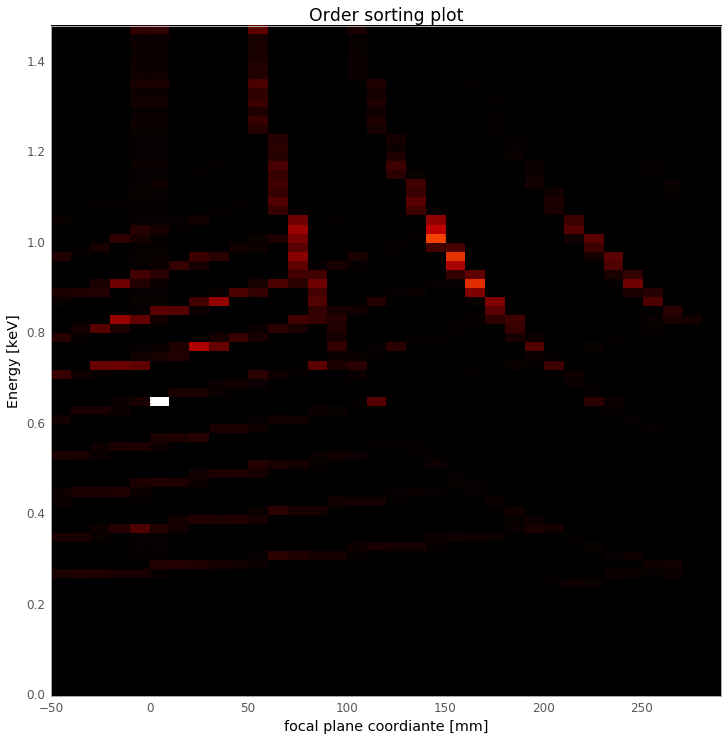

In [38]:
ind = photonfiltertopccds(eqpegA)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
out = ax.hist2d(eqpegA['proj_x'][ind], eqpegA['energy'][ind], weights=eqpegA['probability'][ind],
          bins=[np.arange(-50,300,10.), np.arange(0, 1.5, .02)],
          )#norm=matplotlib.colors.LogNorm())
ax.set_ylabel('Energy [keV]')
ax.set_xlabel('focal plane coordiante [mm]')
temp = ax.set_title('Order sorting plot')